# Synthetic data as a tool to mitigate dataset biases

#### The Adult Census Income dataset is a collection of census data from 1994 mainly used for prediction tasks where the goal is to identify if a person makes over 50K a year (https://archive.ics.uci.edu/ml/datasets/adult). Each person is described by 14 features focused on personal information, including sensitive attributes such as race and sex. When analyzing the race variable, each person can be categorized into one of five classes: White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, and Other. However, the representativeness of each race in the dataset is highly disproportional. The dominant class is "White" in 85.4% of the instances, while the "Other" accounts for 0.8% of the rows, therefore being the minority class. This level of imbalance is also visible in the outcome variable. Only 9.2% of the race "Other" makes over 50K a year, which will highly bias any prediction for this group. This use case tackles this fairness issue by using a YData synthesizer to oversample the "Other" class of the race variable, particularly the 9.2% that makes over 50K a year. The YData synthesizer is compared to the original data and the under-sampling technique, using two classifiers: Random Forest and AdaBoost. The obtained accuracy, F1 score, and recall for 10 independent runs are available in the figure below. The results show that using the YData synthesizer provides the best metrics for the minority class while maintaining stable results for the dominant class and the overall data.

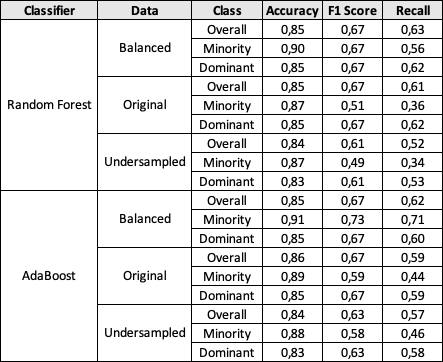

In [7]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, recall_score, accuracy_score
from ydata.labs import DataSources
from ydata.metadata import Metadata
from ydata.dataset.dataset import Dataset
from ydata.profiling import ProfileReport
from ydata.synthesizers.regular.model import RegularSynthesizer

In [8]:
%matplotlib inline 

## Reading the dataset

#### We start by reading the dataset from the YData data sources previously created through the Fabric UI. The Adult Census dataset is already split into the train and test sets, therefore we must read both. Considering the reduced size of the sets, we immediately convert them to Pandas Dataframes.

In [9]:
_CLASSE_POS = ">50K"
_Y_LABEL = "income"
_IMBALANCED_FEATURE = "race"

dsource_train = DataSources.get(uid="78bdcb1a-bd1f-4a3d-bb41-145c5e0c749d",
                                namespace="3f78f948-13cc-450c-b844-03b578091f84")
dataset_train = dsource_train.read()
metadata = Metadata(dataset_train)
dsource_test = DataSources.get(uid="cbfc21c4-7725-4e93-b129-858fbdad66fb",
                               namespace="3f78f948-13cc-450c-b844-03b578091f84")
dataset_test = dsource_test.read()

data_train = dataset_train.to_pandas()
data_test = dataset_test.to_pandas()

### Getting the dataset profile

#### To better understand the data characteristics, we generate a report of the data through pandas-profiling. We can use this report to perform exploratory data analysis. In fact, after exploring the data, we can identify several sensitive categorical features that show high levels of imbalance in their representativeness.  Some examples are sex, race, relationship, and marital status. We focused our use case on the race variable considering its relevance in fairness bias.

In [10]:
report = ProfileReport(data_train, title="Census Income Profiling")
display(HTML(report.to_html()))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Number of variables,15
Number of observations,32561
Missing cells,4262
Missing cells (%),0.9%
Duplicate rows,23
Duplicate rows (%),0.1%
Total size in memory,3.7 MiB
Average record size in memory,120.0 B
Numeric,6
Categorical,9
Dataset has 23 (0.1%) duplicate rows,Duplicates


### Exploring imbalance in the Race variable

#### When further analyzing the representativeness of the race variable, we find a clear dominance of the "White" class in 85.4% of the instances. All the remaining classes are considerably less represented, with the minority class being the "Other" in only 0.8% of the rows. Although any of the underrepresented classes could be tackled in this use case, we focused on the "Other" since it covers different minorities, which aggravates the issue of lack of representation.

<AxesSubplot:xlabel='race', ylabel='count'>

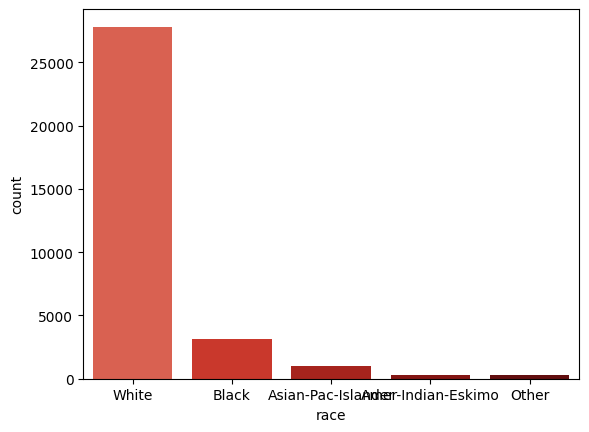

In [11]:
sns.countplot(x=_IMBALANCED_FEATURE, data=data_train,
              palette=["#F04F3A", "#E32212", "#BD0F06", "#960300", "#700002"])

In [12]:
keys, values = data_train[_IMBALANCED_FEATURE].value_counts().keys().values, \
               data_train[_IMBALANCED_FEATURE].value_counts().values
_MINOTIRY_CLASS = keys[np.argmin(values)]
_DOMINANT_CLASS = keys[np.argmax(values)]
_OTHER_CLASSES = np.delete(keys, [np.argmin(values), np.argmax(values)])

#### The imbalance found between classes of the race variable is also visible when considering the outcome variable. Only 9.2% of the race "Other" makes over 50K a year, which will highly bias any prediction for this group. We tackle this fairness issue by using a YData synthesizer to oversample this particular group, aiming to make it better represented in the dataset.

<AxesSubplot:xlabel='income', ylabel='count'>

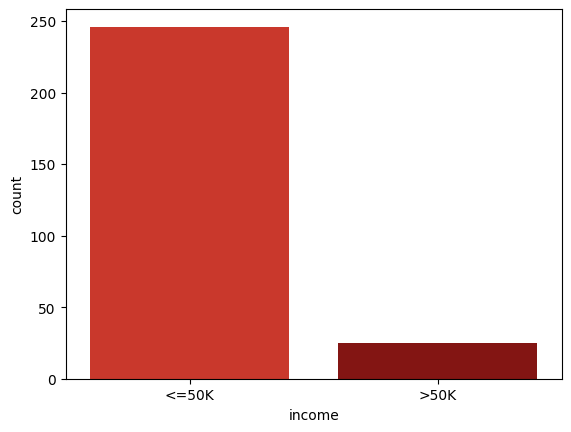

In [13]:
sns.countplot(x=_Y_LABEL, data=data_train[
                data_train[_IMBALANCED_FEATURE] == _MINOTIRY_CLASS],
              palette=["#E32212", "#960300"])

## Balancing the data with synthetic samples

#### We start by filtering our interest group from the training data (instances of the race "Other" where people make over 50K a year). We then train a YData regular synthesizer on this data to sample from it later.

In [14]:
dataset_train_pos = Dataset(data_train[data_train[_Y_LABEL] == _CLASSE_POS])
synthetizer = RegularSynthesizer()
synthetizer.fit(dataset_train_pos, Metadata(dataset_train_pos))

INFO: 2022-12-22 11:11:38,995 [SYNTHESIZER] - Number columns considered for synth: 15
INFO: 2022-12-22 11:11:55,413 [SYNTHESIZER] - Starting the synthetic data modeling process over 1x1 blocks.
INFO: 2022-12-22 11:11:55,417 [SYNTHESIZER] - Preprocess segment
INFO: 2022-12-22 11:11:55,420 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-12-22 11:11:55,421 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.


### Sampling from a trained synthesizer

#### We now generate samples through the synthesizer. We assume the number of new samples will be the size of the train set.

In [15]:
synth_sample = synthetizer.sample(n_samples=data_train.shape[0]).to_pandas()

INFO: 2022-12-22 11:11:56,752 [SYNTHESIZER] - Start generating model samples.


In [16]:
synth_sample.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,Self-emp-not-inc,229341,HS-grad,9,Married-spouse-absent,Transport-moving,Other-relative,Amer-Indian-Eskimo,Male,13550,0,55,United-States,>50K
1,42,Private,228320,Some-college,10,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K
2,52,Private,89534,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K
3,40,Private,116632,Bachelors,13,Married-spouse-absent,Exec-managerial,Other-relative,Black,Male,8614,0,40,United-States,>50K
4,55,Private,156430,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,84,United-States,>50K


#### We perform oversampling on all classes of the race variable, except the dominant one. The imbalance ratio can't surpass 1 (i.e., perfect balance), otherwise we could create a new imbalance issue towards the dominant class. To avoid this behavior, we perform subsampling on the new samples up to the maximum imbalance ratio.

In [17]:
data_train_balanced = copy.deepcopy(data_train)
for imb_class in [*_OTHER_CLASSES, *[_MINOTIRY_CLASS]]:
    imb_diff = data_train[data_train[_IMBALANCED_FEATURE] == _DOMINANT_CLASS].shape[0] \
                - data_train[data_train[_IMBALANCED_FEATURE] == imb_class].shape[0]
    new_samples = synth_sample[synth_sample[_IMBALANCED_FEATURE] == imb_class]
    if new_samples.shape[0] > imb_diff:
        new_samples = new_samples.sample(n=imb_diff)
    data_train_balanced = pd.concat([data_train_balanced, new_samples], axis=0)

#### We can see that the imbalance gap between people of the race "Other" who make more and less than 50K was considerably reduced after the oversampling.

<AxesSubplot:xlabel='income', ylabel='count'>

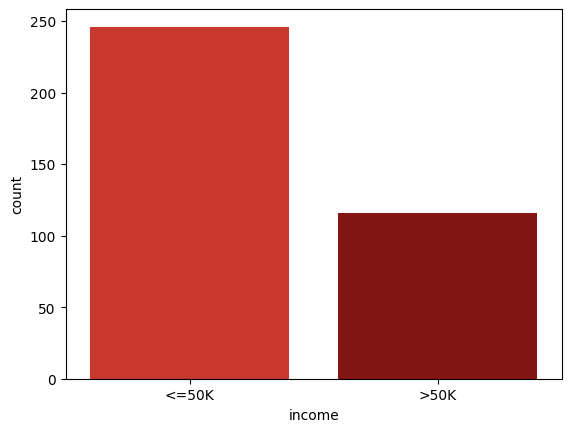

In [18]:
sns.countplot(x=_Y_LABEL, data=data_train_balanced[
                data_train_balanced[_IMBALANCED_FEATURE] == _MINOTIRY_CLASS],
              palette=["#E32212", "#960300"])

### Applying undersample for baseline comparison

#### We also apply the undersampling technique to use as a baseline for comparison.

In [19]:
undersampled_parts = []
sample_size = data_train[data_train[_IMBALANCED_FEATURE] == _MINOTIRY_CLASS].shape[0]
for imb_class in data_train[_IMBALANCED_FEATURE].value_counts().keys().values:
    undersampled_parts.append(data_train[data_train[_IMBALANCED_FEATURE] == imb_class].sample(n=sample_size))
data_train_undersampled = pd.concat(undersampled_parts, axis=0)

#### The imbalance ratio is 1 between all classes, with the selection of the instances to keep being randomly performed.

<AxesSubplot:xlabel='race', ylabel='count'>

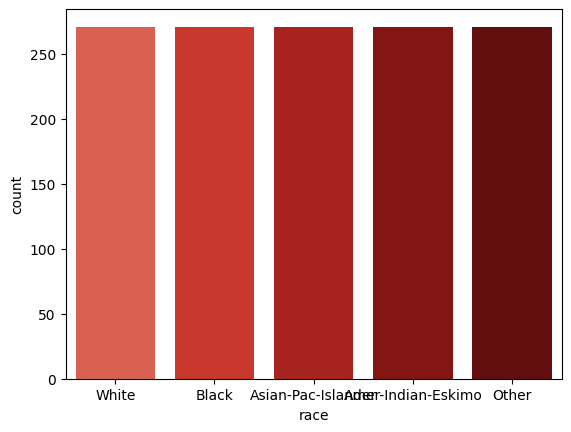

In [20]:
sns.countplot(x=_IMBALANCED_FEATURE, data=data_train_undersampled,
              palette=["#F04F3A", "#E32212", "#BD0F06", "#960300", "#700002"])

## Training classifiers

### Preprocessing the data before training

#### Before training the classifiers, we need to preprocess the data. A necessary step is to encode all the categorical features into a numeric representation. We use the scikit-learn LabelEncoder for that purpose. Since our data contains missing values in several features, we also encode them. Afterward, we convert them back to NaNs. 

In [21]:
for col in metadata.categorical_vars:
    if metadata.columns[col].vartype.value == "string":
        has_nan = data_train[col].isnull().values.any()
        if has_nan:
            data_train[col] = data_train[col].fillna("<NA>").astype(str)
            data_train_balanced[col] = data_train_balanced[col].fillna("<NA>").astype(str)
            data_train_undersampled[col] = data_train_undersampled[col].fillna("<NA>").astype(str)
            data_test[col] = data_test[col].fillna("<NA>").astype(str)

        le = LabelEncoder()
        le.fit(data_train[col].astype(str))
        data_train[col] = le.transform(data_train[col]).astype("int")
        data_train_balanced[col] = le.transform(data_train_balanced[col]).astype("int")
        data_train_undersampled[col] = le.transform(data_train_undersampled[col]).astype("int")
        data_test[col] = le.transform(data_test[col]).astype("int")

        if has_nan:
            nan_enc_value = le.transform(["<NA>"])[0]
            data_train[col] = data_train[col].replace(nan_enc_value, np.nan)
            data_train_balanced[col] = data_train_balanced[col].replace(nan_enc_value, np.nan)
            data_train_undersampled[col] = data_train_undersampled[col].replace(nan_enc_value, np.nan)
            data_test[col] = data_test[col].replace(nan_enc_value, np.nan)

        if col == _IMBALANCED_FEATURE:
            _DOMINANT_CLASS_INT = le.transform([_DOMINANT_CLASS])[0]
            _MINOTIRY_CLASS_INT = le.transform([_MINOTIRY_CLASS])[0]
            _OTHER_CLASSES_INT = le.transform(_OTHER_CLASSES)

### Performing missing data imputation

#### To address the missing data issue, we perform a simple imputation procedure: the missing values are replaced by the feature's mean or mode, depending if they are continuous or categorical variables. This strategy is applied independently to every version of the dataset to avoid bias.

In [22]:
for col in data_train.columns:
    strategy = "mean" if col in metadata.numerical_vars else "most_frequent"
    data_train[col] = SimpleImputer(missing_values=np.nan, strategy=strategy).fit_transform(data_train[col].values.reshape(-1, 1))
    data_train_balanced[col] = SimpleImputer(missing_values=np.nan, strategy=strategy).fit_transform(data_train_balanced[col].values.reshape(-1, 1))
    data_train_undersampled[col] = SimpleImputer(missing_values=np.nan, strategy=strategy).fit_transform(data_train_undersampled[col].values.reshape(-1, 1))
    data_test[col] = SimpleImputer(missing_values=np.nan, strategy=strategy).fit_transform(data_test[col].values.reshape(-1, 1))

### Fitting and predicting with the classifiers

#### We start by separating the outcome variable from the independent features in every version of the dataset.

In [23]:
training_data = {
    "original": (data_train.drop(columns=_Y_LABEL), data_train[_Y_LABEL]),
    "balanced": (data_train_balanced.drop(columns=_Y_LABEL), data_train_balanced[_Y_LABEL]),
    "undersampled": (data_train_undersampled.drop(columns=_Y_LABEL), data_train_undersampled[_Y_LABEL])
}

test_data = (data_test.drop(columns=_Y_LABEL), data_test[_Y_LABEL])

#### We then train two classifiers (Random Forest and AdaBoost) on every version of the training set and evaluate the accuracy, F1 score and recall on the test set. The results are also independently evaluated for the overall data, the dominant class ("White") and the minority one ("Other"). The results for these three metrics are saved in a Pandas Dataframe and presented through bar charts in small multiples.

In [24]:
models = [RandomForestClassifier, AdaBoostClassifier]
x_test, y_test = test_data

results = pd.DataFrame(columns=["Classifier", "Data", "Class", "Metric", "Result"])

for model in models:
    for type_data, train_data in training_data.items():
        clf_model = model(random_state=42)
        clf_model.fit(train_data[0], train_data[1])
        all_classes = [None, _DOMINANT_CLASS_INT, _MINOTIRY_CLASS_INT]
        for imb_class in all_classes:
            if imb_class is None:
                pred = clf_model.predict(x_test)
                gt = y_test
                class_name = "Overall"
            else:
                pred = clf_model.predict(x_test[x_test[_IMBALANCED_FEATURE] == imb_class])
                gt = y_test[x_test[_IMBALANCED_FEATURE] == imb_class]
                class_name = "Dominant" if imb_class == _DOMINANT_CLASS_INT else "Minority"

            new_entries = pd.DataFrame.from_dict({
                "Classifier": [model.__name__.replace("Classifier", "")] * 3,
                "Data": [type_data.capitalize()] * 3,
                "Class": [class_name] * 3,
                "Metric": ["Accuracy", "F1 Score", "Recall"],
                "Result": [np.round(accuracy_score(gt, pred), 2),
                           np.round(f1_score(gt, pred), 2),
                           np.round(recall_score(gt, pred), 2)]
            })
            results = pd.concat([results, new_entries], ignore_index=True)

#### Using the YData synthesizer for oversampling purposes provides the best results for the minority class without deteriorating the results for the dominant class and the overall data.

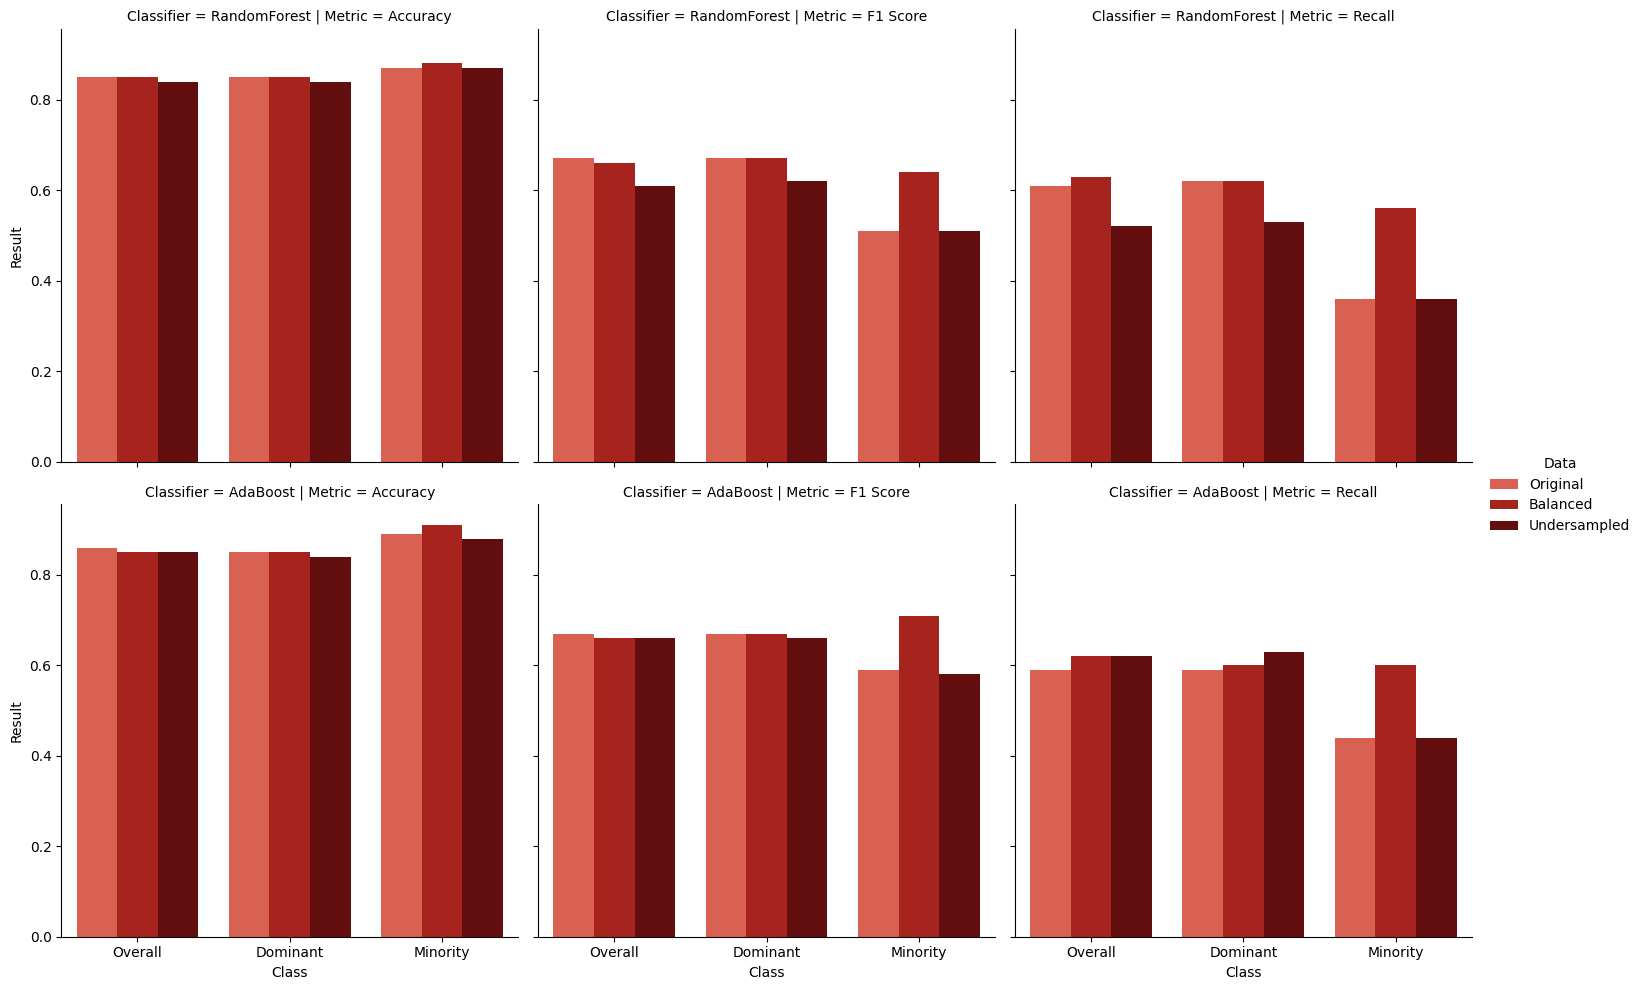

In [25]:
sns.catplot(
    data=results, x="Class", y="Result",
    hue="Data", col="Metric", row="Classifier",
    kind="bar", palette=["#F04F3A", "#BD0F06", "#700002"])